# Problema 8

In [1]:
# uncomment to install missing libraries
# install.packages('nnet')
# install.packages('caret')
# install.packages('cclust')

In [2]:
options(repr.plot.width=6, repr.plot.height=6)

In [3]:
library(MASS)
library(nnet)
set.seed (4567)

## Permeabilitat de roques amb la xarxa MLP [R]

Es disposa de 48 mesures de roques d'un dipòsit de petroli. L'objectiu és modelar la permeabilitat en funció de l'àrea, el perímetre i la forma. En primer lloc transformem les dades per ajudar a l'ajust del model:

In [4]:
library(datasets)
data(rock)
?rock
rock.x <- data.frame(area = scale(rock$area), perim = scale(rock$peri), shape = scale(rock$shape))
rock.y <- log(rock$perm)

Entreneu una xarxa MLP per aprendre la tasca. Donat el baix número d'exemples, useu leave-one-out cross-validation i regularització per trobar la millor xarxa. Per avaluar el model, feu una gràfica de resposta predita vs. observada i guieu-vos per l'error quadràtic predictiu.

In [5]:
head(rock)
N <- nrow(rock)

area,peri,shape,perm
<int>,<dbl>,<dbl>,<dbl>
4990,2791.90,0.0903296,6.3
7002,3892.60,0.1486220,6.3
7558,3930.66,0.1833120,6.3
7352,3869.32,0.1170630,6.3
7943,3948.54,0.1224170,17.1
7979,4010.15,0.1670450,17.1


 We will treat all the variables gre and gpa as continuous. 

The variable rank takes on the values 1 through 4, so we can fairly treat it as numerical
(although, in rigour, it is ordinal)

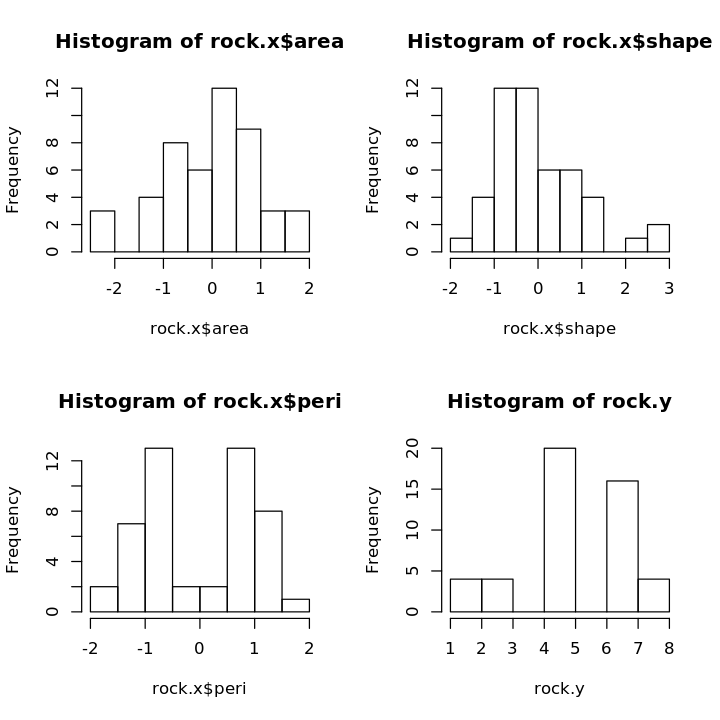

In [6]:
par(mfcol=c(2,2))
hist(rock.x$area)
hist(rock.x$peri)
hist(rock.x$shape)
hist(rock.y)

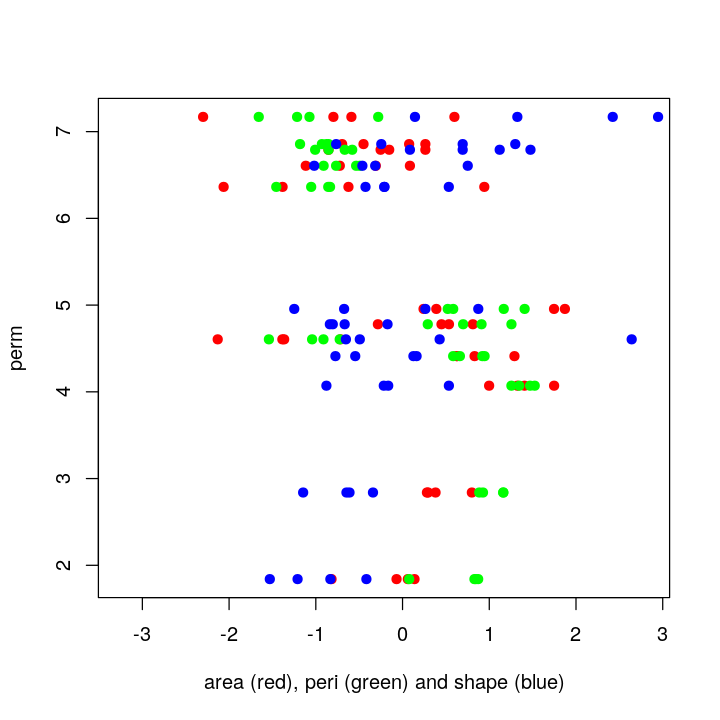

In [39]:
plot(rock.x$area, rock.y, col="red", pch=19, asp=1, xlab="area (red), peri (green) and shape (blue)", ylab="perm")
points(rock.x$peri, rock.y, col="green",pch=19, asp=1)
points(rock.x$shape, rock.y, col="blue",pch=19, asp=1)

In [40]:
rockScale <- data.frame(area = scale(rock$area),
                        peri = scale(rock$peri),
                        shape = scale(rock$shape),
                        perm = scale(rock$perm))
head(rockScale)

area,peri,shape,perm
<dbl>,<dbl>,<dbl>,<dbl>
-0.81887218,0.07661594,-1.5303744,-0.9345203
-0.06920254,0.84544311,-0.8322322,-0.9345203
0.13796262,0.87202761,-0.4167654,-0.9345203
0.06120718,0.82918228,-1.2102003,-0.9345203
0.28141333,0.88451660,-1.1460778,-0.9098525
0.29482690,0.92755052,-0.6115880,-0.9098525


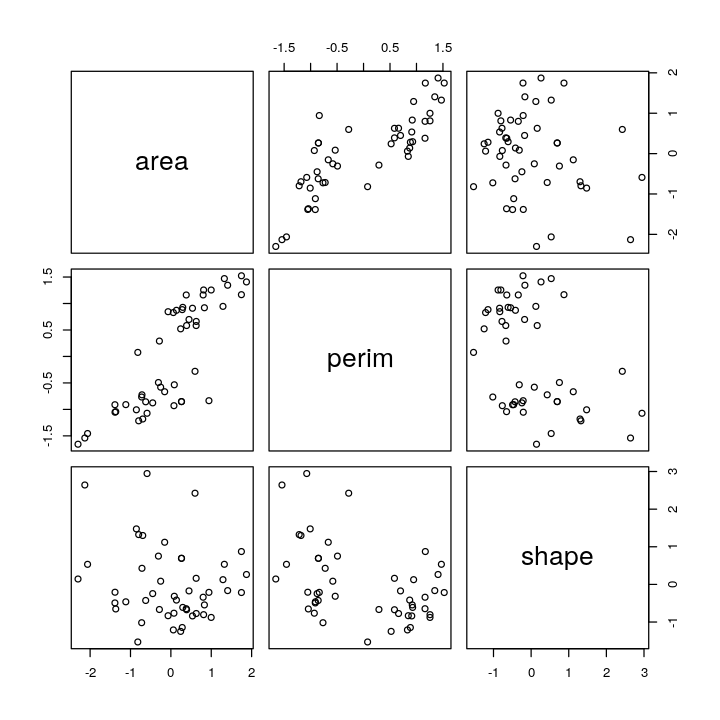

In [9]:
plot(rock.x)

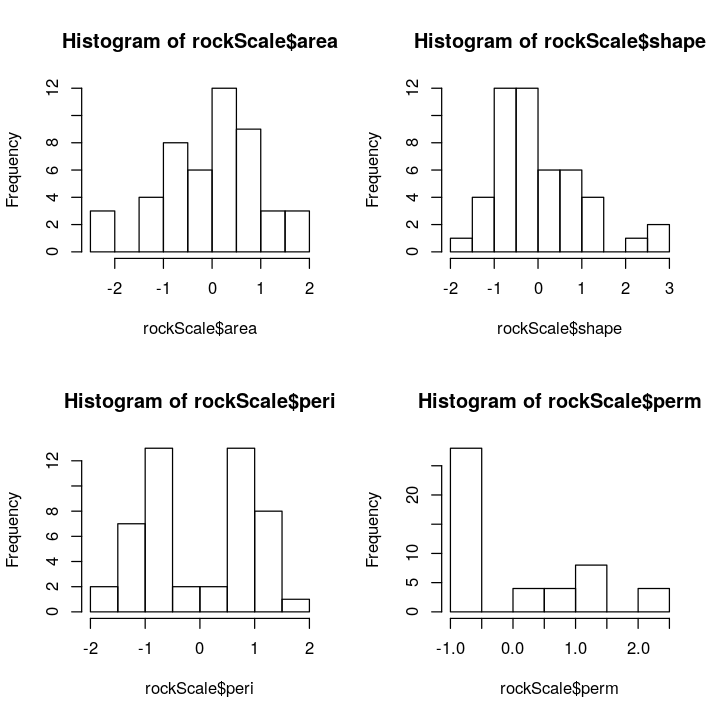

In [41]:
par(mfcol=c(2,2))
hist(rockScale$area)
hist(rockScale$peri)
hist(rockScale$shape)
hist(rockScale$perm)

 We first split the available data into learning and test sets, selecting randomly 2/3 and 1/3 of the data
 We do this for a honest estimation of prediction performance

In [42]:
set.seed(43)

learn <- sample(1:N, round(2*N/3))

nlearn <- length(learn)
ntest <- N - nlearn

We start using logistic regression (a linear classifier)

In [43]:
model.logreg <- glm (perm~., data=rockScale[learn,], family=gaussian)
summary(model.logreg)


Call:
glm(formula = perm ~ ., family = gaussian, data = rockScale[learn, 
    ])

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.36929  -0.15008   0.08179   0.24061   1.06200  

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.04305    0.09405   0.458   0.6506    
area         0.28783    0.16978   1.695   0.1011    
peri        -0.92231    0.18331  -5.031 2.55e-05 ***
shape        0.33543    0.13281   2.526   0.0175 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.2703587)

    Null deviance: 30.067  on 31  degrees of freedom
Residual deviance:  7.570  on 28  degrees of freedom
AIC: 54.683

Number of Fisher Scoring iterations: 2


Simplify the model using the AIC

In [44]:
model.logreg2 <- step(model.logreg, family=gaussian)

Start:  AIC=54.68
perm ~ area + peri + shape

        Df Deviance    AIC
<none>       7.5700 54.683
- area   1   8.3471 55.810
- shape  1   9.2945 59.250
- peri   1  14.4141 73.291


 The new model has one variable less and the error (residual deviance) is virtually the same (313.5 vs 312.2)

 Interpretation of the coefficients

In [45]:
exp(model.logreg2$coefficients)

(Intercept)        area        peri       shape 
  1.0439934   1.3335320   0.3975993   1.3985369

Calculation of apparent error in the training set (learn)

In [47]:
glfpred=NULL
glfpred[model.logreg2$fitted.values<0.5]=0
glfpred[model.logreg2$fitted.values>=0.5]=1
table(rockScale$perm[learn],glfpred)
error_rate.learn <- 100*(1-sum(diag(table(rockScale$perm[learn],glfpred)))/nlearn)
error_rate.learn

                    glfpred
                     0 1
  -0.934520254211691 4 0
  -0.909852482623065 3 0
  -0.815064286240845 2 0
  -0.760703826628874 2 0
  -0.720504495151113 1 1
  -0.677107489578531 1 0
  -0.624574272306457 4 0
  0.375840908787813  0 3
  0.741289376767455  2 1
  1.08389731549837   0 2
  1.22094049099074   0 4
  2.0203590146962    0 2

[1] 87.5

 we get a learning error which is quite high (28.84%)

 Estimation of prediction error using the test set

In [49]:
glft = predict(model.logreg2, newdata=rock[-learn,]) 
pt = 1/(1+exp(-glft))
glfpredt = NULL
glfpredt[pt<0.5]=0
glfpredt[pt>=0.5]=1
table(rockScale$perm[-learn],glfpredt)
error_rate.test <- 100*(1-sum(diag(table(rockScale$perm[-learn],glfpredt)))/ntest)
error_rate.test

                    glfpredt
                     0 1
  -0.909852482623065 1 0
  -0.815064286240845 2 0
  -0.760703826628874 2 0
  -0.720504495151113 2 0
  -0.677107489578531 3 0
  0.375840908787813  1 0
  0.741289376767455  0 1
  1.08389731549837   0 2
  2.0203590146962    0 2

[1] 93.75

 we get a prediction error of 27.07%

 Now we switch to non-linear modelling with a MLP

 The nnet() function is quite powerful and very reliable from the optimization
 point fo view. From the computational point of view, it has two drawbacks:

1. it does not have a built-in mechanism for multiple runs or cross-validation
2. it only admits networks of one hidden layer (of size 'size')

Please have a look at nnet before going any further

In [25]:
?nnet

The basic parameters are 'size' and 'decay' (the regularization constant, lambda)
 As usual, R detects it is a classification problem because 'admit' is a factor
 It buils a MLP with one output neuron (just two classes), with the logistic function
and uses the cross-entropy as error function

 Let's start by scaling of inputs, this is important to avoid network 'stagnation' (premature convergence)

In [ ]:
#rock$area <- scale(rock$area)
#rock$shape <- scale(rock$shape)
#rock$peri <- scale(rock$peri)
#rock$perm <- scale(rock$perm)
#head(rock)

To illustrate the first results, we just fit a MLP with 2 hidden neurons

In [50]:
model.nnet <- nnet(perm ~., data = rockScale, subset=learn, size=2, maxit=2000, decay=0)

# weights:  11
initial  value 35.373569 
iter  10 value 30.068110
iter  20 value 30.067430
iter  30 value 30.060204
iter  40 value 30.059483
iter  50 value 30.058622
iter  60 value 30.057577
iter  70 value 30.056283
iter  80 value 30.054636
iter  90 value 30.052473
iter 100 value 30.049506
iter 110 value 30.045187
iter 120 value 30.038330
iter 130 value 30.025811
iter 140 value 29.995983
iter 150 value 29.845400
iter 160 value 19.593956
iter 170 value 19.501890
iter 180 value 17.888267
iter 190 value 17.519570
iter 200 value 17.477877
iter 210 value 17.477648
iter 220 value 17.476767
iter 230 value 17.476293
final  value 17.476059 
converged


 Take your time to understand the output

In [51]:
model.nnet 

a 3-2-1 network with 11 weights
inputs: area peri shape 
output(s): perm 
options were -

 Result 3 neur. -> 2 neur. -> 1 neur.
 
 5 bias: 3+2
 
 In particular, understand why the total number of weights is 11, what 'initial  value' and 'final  value' are
 and what does 'converged' mean

 This is the final value of the error function (also known as fitting criterion)

In [52]:
model.nnet$value

[1] 17.47606

  fitted values for the training data

In [53]:
fval_res <- cbind(matrix=model.nnet$fitted.values, model.nnet$residuals)
colnames(fval_res) <- c("Fit. val.", "Residuals")
print(fval_res)

      Fit. val.   Residuals
44 0.9294251453  1.09093387
40 0.9294237483 -1.64992824
4  0.0000000000 -0.93452025
21 0.0000000000 -0.62457427
2  0.0000000000 -0.93452025
5  0.0000000000 -0.90985248
26 0.7194312469  0.02185813
24 0.0000000000 -0.62457427
13 0.0000000000 -0.76070383
7  0.0000000000 -0.90985248
48 0.9294251453 -0.55358424
31 0.9294251453  0.15447217
22 0.0000000000 -0.62457427
39 0.0008706995 -0.72137519
14 0.0000000000 -0.76070383
33 0.9291557719  0.29178472
29 0.9293912972  0.15450602
20 0.0000000000 -0.81506429
19 0.0000000000 -0.81506429
47 0.9205877266 -0.54474682
36 0.9294251453  0.29151535
8  0.0000000000 -0.90985248
34 0.9294251453  0.29151535
46 0.9294251453 -0.55358424
3  0.0000000000 -0.93452025
42 0.9294074307  1.09095158
1  0.0000000000 -0.93452025
23 0.0000000000 -0.62457427
27 0.9282294215 -0.18694004
10 0.0000000000 -0.67710749
25 0.9294251453 -0.18813577
35 0.9240677508  0.29687274


 and the residuals

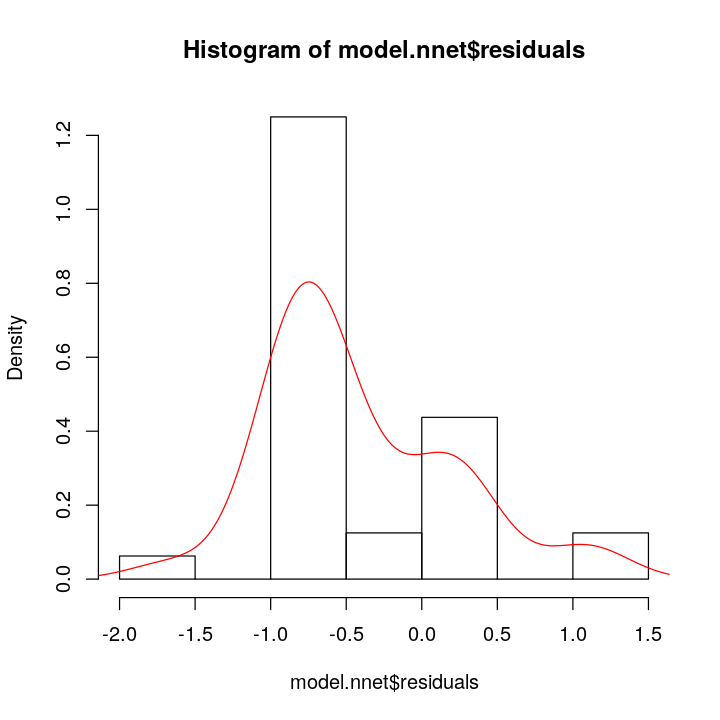

In [54]:
dens <- density(model.nnet$residuals)
hist(model.nnet$residuals, prob=T)
lines(dens,col="red")

In [55]:
prediction <- predict(model.nnet)
prediction

44,0.9294251453
40,0.9294237483
4,0.0000000000
21,0.0000000000
2,0.0000000000
5,0.0000000000
26,0.7194312469
24,0.0000000000
13,0.0000000000
7,0.0000000000
48,0.9294251453


In [65]:


model.glm.fit = glm(perm ~ ., data=rockScale, family=gaussian)

#loocv.err <- model.glm(rock, glm.fit)
#eval.res <- loocv(rock.x, rock.y)
#LOOCV
#cv <- glm(rock, glm.fit, family=gaussian)$delta 

#eval.res <- loocv(learner('user.rpart',pars=list()),
#                  dataset(perm ~ ., rock),
#                  loocvSettings(1234))

 Now look at the weights

In [66]:
model.nnet$wts

[1]  1.5030657 -1.9280694  4.1440122 -0.6112762  1.5014920 -1.9288735
 [7]  4.1427034 -0.6119041  4.2106405 -5.2987090 -5.2990053

I think this way is clearer:

In [67]:
summary(model.nnet)

a 3-2-1 network with 11 weights
options were - decay=0.01
 b->h1 i1->h1 i2->h1 i3->h1 
  1.50  -1.93   4.14  -0.61 
 b->h2 i1->h2 i2->h2 i3->h2 
  1.50  -1.93   4.14  -0.61 
 b->o h1->o h2->o 
 4.21 -5.30 -5.30 

 i1,i2,i3 are the 3 inputs, h1, h2 are the two hidden neurons, b is the bias (offset)

 As you can see, some weights are large (two orders of magnitude larger then others)
This is no good, since it makes the model unstable (i.e., small changes in some inputs may
 entail significant changes in the network, because of the large weights)

 One way to avoid this is by regularizing the learning process:

In [68]:
model.nnet <- nnet(perm ~., data = rockScale, 
                   subset=learn, size=2, maxit=200, decay=0.01)

# weights:  11
initial  value 33.125309 
iter  10 value 30.011689
iter  20 value 18.426957
iter  30 value 17.990513
iter  40 value 17.966931
iter  50 value 17.961229
iter  60 value 17.960806
final  value 17.960798 
converged


 notice the big difference

In [69]:
model.nnet$wts

summary(model.nnet)

[1] -1.6424035  1.7977754 -3.8721788  0.5517948  1.7707848 -1.9341048
 [7]  4.1284409 -0.5395835 -0.2219640  5.5988653 -6.0696425

a 3-2-1 network with 11 weights
options were - decay=0.01
 b->h1 i1->h1 i2->h1 i3->h1 
 -1.64   1.80  -3.87   0.55 
 b->h2 i1->h2 i2->h2 i3->h2 
  1.77  -1.93   4.13  -0.54 
 b->o h1->o h2->o 
-0.22  5.60 -6.07 

Now let's compute the training error

In [70]:
pred <- predict(model.nnet)
p1 <- as.factor(pred)

t1 <- table(p1,rockScale$perm[learn])
error_rate.learn <- 100*(1-sum(diag(t1))/nlearn)
error_rate.learn

[1] 100

 And the corresponding test error

In [71]:
pred2 <- predict(model.nnet, newdata=rockScale[-learn,])
p2 <- as.factor(pred2)

t2 <- table(p2,rockScale$perm[-learn])
error_rate.test <- 100*(1-sum(diag(t2))/ntest)
error_rate.test

[1] 100

 We get 26.32%, so it seems that the MLP helps a little bit; however, we need to work harder

 We are going to do the modelling in a principled way now. Using 10x10 CV to select the best
 combination of 'size' and 'decay'

 Just by curiosity, let me show you that we can fit any dataset (in the sense of reducing the training error):

In [73]:
model.nnet <- nnet(perm ~., data = rockScale, 
                   subset=learn, size=20, maxit=200, trace=T)

# weights:  101
initial  value 37.074438 
final  value 30.068357 
converged


 Now let's compute the training error

In [74]:
p1 <- as.factor(predict (model.nnet))

(t1 <- table(p1,rockScale$perm[learn]))
error_rate.learn <- 100*(1-sum(diag(t1))/nlearn)
error_rate.learn

   
p1  -0.934520254211691 -0.909852482623065 -0.815064286240845 -0.760703826628874
  0                  4                  3                  2                  2
   
p1  -0.720504495151113 -0.677107489578531 -0.624574272306457 0.375840908787813
  0                  2                  1                  4                 3
   
p1  0.741289376767455 1.08389731549837 1.22094049099074 2.0203590146962
  0                 3                2                4               2

[1] 87.5

And the corresponding test error

In [75]:
p2 <- as.factor(predict (model.nnet, 
                         newdata=rockScale[-learn,]))

t2 <- table(p2,rockScale$perm[-learn])
error_rate.test <- 100*(1-sum(diag(t2))/ntest)
error_rate.test
t2

[1] 93.75

   
p2  -0.909852482623065 -0.815064286240845 -0.760703826628874 -0.720504495151113
  0                  1                  2                  2                  2
   
p2  -0.677107489578531 0.375840908787813 0.741289376767455 1.08389731549837
  0                  3                 1                 1                2
   
p2  2.0203590146962
  0               2

That's it: we got a training error around 6% (four times lower than the previous one), but it is 
illusory ... the test error is larger than before (around 40%); 
 The relevant comparison is between 6% and 40%, this large gap is an indication of overfitting


{caret} is an excellent package for training control, once you know what all these concepts are

 WARNING: if the package is not installed in your computer, installation needs some previous packages

In [76]:
library(caret)

Loading required package: lattice
Loading required package: ggplot2
Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


For a specific model, in our case the neural network, the function train() in {caret} uses a "grid" of model parameters
 and trains using a given resampling method (in our case we will be using 10x10 CV). All combinations are evaluated, and 
 the best one (according to 10x10 CV) is chosen and used to construct a final model, which is refit using the whole training set

 Thus train() returns the constructed model (exactly as a direct call to nnet() would)

 In order to find the best network architecture, we are going to explore two methods:

1. Explore different numbers of hidden units in one hidden layer, with no regularization
2. Fix a large number of hidden units in one hidden layer, and explore different regularization values (recommended)

doing both (explore different numbers of hidden units AND regularization values) is usually a waste of computing 
resources (but notice that train() would admit it)

Let's start with 1.

set desired sizes

In [77]:
(sizes <- 2*seq(1,10,by=1))

[1]  2  4  6  8 10 12 14 16 18 20

 specify 10x10 CV

In [78]:
trc <- trainControl (method="repeatedcv", number=10, repeats=10)

model.10x10CV <- train (perm ~., 
                        data = rockScale, 
                        subset=learn, 
                        method='nnet', 
                        maxit = 500, 
                        trace = FALSE,
                        tuneGrid = expand.grid(.size=sizes,.decay=1), 
                        trControl=trc)

 We can inspect the full results

In [79]:
model.10x10CV$results

size,decay,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,1,0.9378647,0.8272966,0.8815217,0.1947282,0.2765840,0.2119854
4,1,0.9359279,0.8235874,0.8820515,0.1992175,0.2778576,0.2123657
6,1,0.9373778,0.8209894,0.8861838,0.2028675,0.2782156,0.2121272
8,1,0.9400963,0.8188807,0.8903492,0.2050877,0.2782328,0.2114556
10,1,0.9427459,0.8175215,0.8939416,0.2071478,0.2784922,0.2107877
12,1,0.9443982,0.8165330,0.8967933,0.2087985,0.2776533,0.2101502
14,1,0.9444659,0.8152123,0.8972309,0.2104285,0.2789632,0.2109791
16,1,0.9461887,0.8149009,0.8988684,0.2113234,0.2790483,0.2104442
18,1,0.9474339,0.8143022,0.9008237,0.2118458,0.2783206,0.2097770


and the best model found

In [80]:
model.10x10CV$bestTune

,size,decay
,<dbl>,<dbl>
2,4,1


 The results are quite disappointing ...

 Now method 2.

In [81]:
(decays <- 10^seq(-3,0,by=0.1))

[1] 0.001000000 0.001258925 0.001584893 0.001995262 0.002511886 0.003162278
 [7] 0.003981072 0.005011872 0.006309573 0.007943282 0.010000000 0.012589254
[13] 0.015848932 0.019952623 0.025118864 0.031622777 0.039810717 0.050118723
[19] 0.063095734 0.079432823 0.100000000 0.125892541 0.158489319 0.199526231
[25] 0.251188643 0.316227766 0.398107171 0.501187234 0.630957344 0.794328235
[31] 1.000000000

 WARNING: this takes a few minutes

In [82]:
model.10x10CV <- train (perm ~., 
                        data = rockScale, 
                        subset=learn, 
                        method='nnet', 
                        maxit = 500, 
                        trace = FALSE,
                        tuneGrid = expand.grid(.size=4,.decay=decays), 
                        trControl=trc)

We can inspect the full results

In [83]:
model.10x10CV$results

size,decay,RMSE,Rsquared,MAE,RMSESD,RsquaredSD,MAESD
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,0.001000000,0.8482192,0.7077581,0.7772288,0.2401889,0.3512318,0.2286116
4,0.001258925,0.8503378,0.7196646,0.7758277,0.2466863,0.3433773,0.2307740
4,0.001584893,0.8532749,0.7061067,0.7802644,0.2463444,0.3590701,0.2317907
4,0.001995262,0.8478928,0.7267785,0.7743717,0.2371077,0.3377564,0.2218633
4,0.002511886,0.8401026,0.7281255,0.7732177,0.2348601,0.3464456,0.2231760
4,0.003162278,0.8398366,0.7197382,0.7735324,0.2447607,0.3487855,0.2268941
4,0.003981072,0.8182338,0.7433650,0.7490027,0.2393347,0.3264302,0.2228816
4,0.005011872,0.8117405,0.7527909,0.7431755,0.2376750,0.3251022,0.2198200
4,0.006309573,0.7931436,0.7784552,0.7286804,0.2300820,0.3041619,0.2167109


and the best model found

In [84]:
model.10x10CV$bestTune

save(model.10x10CV, file = "model.10x10CV.regul")

load ("model.10x10CV.regul")

,size,decay
,<dbl>,<dbl>
14,4,0.01995262


 The results are a bit better; we should choose the model with the lowest 10x10CV error overall,
 in this case it corresponds to 20 hidden neurons, with a decay of 0.3162278

 So what remains is to predict the test set with our final model

In [86]:
p2 <- as.factor(predict (model.10x10CV, newdata=rockScale[-learn,], type="raw"))

t2 <- table(pred=p2,truth=rockScale$perm[-learn])
error_rate.test <- 100*(1-sum(diag(t2))/ntest)
error_rate.test


[1] 100

 We get 27.82% after all this work; it seems that the information in this dataset is not enough
 to accurately predict admittance. Note that ...

 ... upon looking at the confusion matrix for the predictions ...

In [87]:
t2

                     truth
pred                  -0.909852482623065 -0.815064286240845 -0.760703826628874
  0.00131762979251415                  0                  0                  0
  0.00156794739696169                  1                  0                  0
  0.00174738646178539                  0                  0                  0
  0.00201868085456734                  0                  1                  0
  0.00205597099407289                  0                  1                  0
  0.00249251475401267                  0                  0                  1
  0.0034092636150443                   0                  0                  1
  0.00352084485782655                  0                  0                  0
  0.12828485798331                     0                  0                  0
  0.169593965368266                    0                  0                  0
  0.385896440132167                    0                  0                  0
  0.941224592818482      

In [88]:
yhat <- as.numeric(predict(model.10x10CV, newdata=rockScale[-learn,], type="raw"))

yhat2 <- table(pred=yhat,truth=rockScale$perm[-learn])
error_rate.test <- 100*(1-sum(diag(yhat2))/ntest)
error_rate.test
yhat2

[1] 100

                     truth
pred                  -0.909852482623065 -0.815064286240845 -0.760703826628874
  0.00131762979251415                  0                  0                  0
  0.00156794739696169                  1                  0                  0
  0.00174738646178539                  0                  0                  0
  0.00201868085456734                  0                  1                  0
  0.00205597099407289                  0                  1                  0
  0.00249251475401267                  0                  0                  1
  0.0034092636150443                   0                  0                  1
  0.00352084485782655                  0                  0                  0
  0.12828485798331                     0                  0                  0
  0.169593965368266                    0                  0                  0
  0.385896440132167                    0                  0                  0
  0.941224592818482      

 it clearly suggests that quite a lot of people is getting accepted when they should not, given their gre, gpa and rank
 It is very likely that other (subjective?) factors are being taken into account, that are not in the dataset

***